# Quantum Efficiency Analysis Workbook

Import Dependencies

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import scipy
from integrating_sphere_funcs import sphere_flux_correction
from cosmos_helper_funcs import label_plot, get_stacks, cosmos_gain_dict
global c
c = 2.998 * 10 ** 10 # speed of light in cm/s
global h
h = 6.626 * 10 ** -27 # Planck's constant in g cm^2/s
this_dir = os.getcwd()

Create a class representing a calibrated photodiode with its associated response curve.

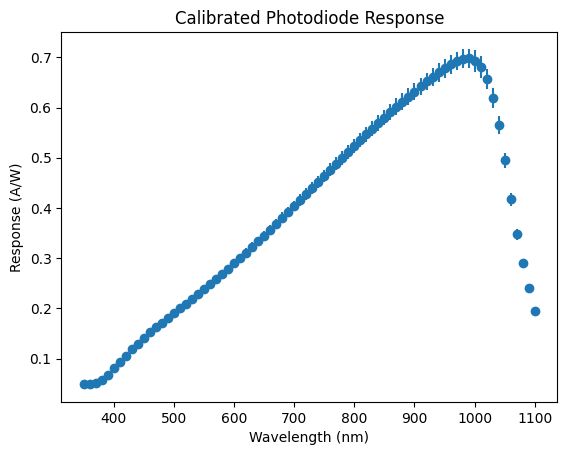

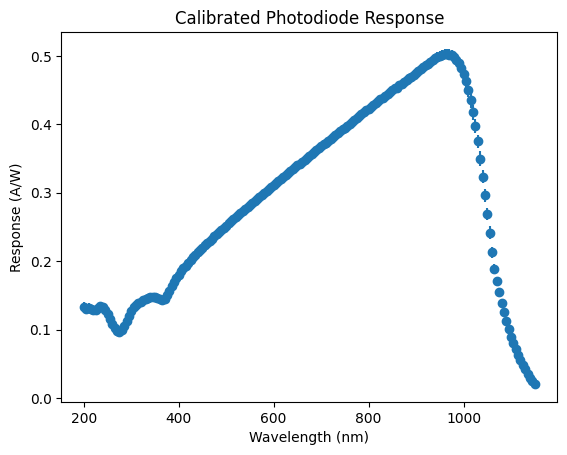

In [26]:
class CalibratedPD(object):
    '''A class to represent a calibrated photodiode.
    
    Attributes:
    ------------
    filename : str
        The complete path to the FITS or csv file containing the calibrated
        photodiode response. The data should have three columns:
        wavelength (nm), response (A/W), and uncertainty in response
        (percent).
    response : numpy.ndarray
        The calibrated photodiode response. First column is
        wavelength in nm, second column is response in A/W. Third
        column is uncertainty in response, in percent.
    area : float
        The area of the photodiode active area, in cm^2.
    plot : bool
        If True, a plot of the response will be generated.
    '''
    def __init__(self, filename, area, plot=False):
        if filename.endswith('.fits'):
            self.response = fits.getdata(filename)
        elif filename.endswith('.csv'):
            self.response = np.genfromtxt(filename, delimiter=',')
        self.area = area
        self.plot = plot
        if plot:
            self.plot_response()

    def plot_response(self):
        '''Plot the calibrated photodiode response.'''
        fig, ax = plt.subplots()
        errors = self.response[:,2] * self.response[:,1] / 100
        ax.errorbar(self.response[:,0], self.response[:,1],
                    yerr=errors, fmt='o')
        ax.set_xlabel('Wavelength (nm)')
        ax.set_ylabel('Response (A/W)')
        ax.set_title('Calibrated Photodiode Response')
        plt.show()

    def get_response(self, wavelength):
        '''Returns the calibrated photodiode response at a given wavelength.'''
        response = np.interp(wavelength, self.response[:,0], self.response[:,1])
        return response
    
data_dir = this_dir + '/data/'
thorlabs_filename = os.path.join(data_dir, 'ThorLabsPD.csv')
hamamatsu_filenmae = os.path.join(data_dir, 'HamamatsuPD.csv')
thorlabs_pd = CalibratedPD(thorlabs_filename, 1, plot=True)
hamamatsu_pd = CalibratedPD(hamamatsu_filenmae, 1, plot=True)


Each image file should have format <wavelength>nm_<exposure_time>ms_<gray/dark>_<num>.fits

Create a class to input data from exposures at different wavelengths and calculate the QE. It also includes a method to estimate the depletion depth.

In [4]:
class QECalc(object):

    def __init__(self, wavelengths, exp_times, pd_dark_vals, pd_gray_vals,
                 img_dark_vals, img_gray_vals, pix_area, gain, pd,
                 pd_pos=np.array([1,1]), sensor_pos=np.array([1,1]), sensor_size=0,
                 int_sphere_port=4):
        '''Initializes the QECalc object with the necessary data to calculate the QE of the camera.

        Parameters:
        ----------
        wavelengths : numpy.ndarray
            The wavelength for each exposure, in nm.
        exp_times : numpy.ndarray
            The exposure time for each wavelength value, in s. For each wavelength value,
            two exposures are taken at the corresponding exposure time: one with the
            shutter closed and one with the shutter open.
        pd_dark_vals : numpy.ndarray
            The average current measured by the calibrated photodiode for each exposure
            with the shutter closed, in A.
        pd_gray_vals : numpy.ndarray
            The average current measured by the calibrated photodiode for each exposure
            with the shutter open, in A.
        img_dark_vals : numpy.ndarray
            The average pixel value for each exposure with the shutter closed.
        img_gray_vals : numpy.ndarray
            The average pixel value for each exposure with the shutter open.
        pix_area : float
            The area of each pixel in the camera, in cm^2.
        gain : float
            The gain of the camera, in ADU/e-.
        pd: CalibratedPD object
            The calibrated photodiode object used to calculate photon flux.
        pd_pos : numpy.ndarray (optional, default=[1,1])
            The position of the photodiode relative to the integrating sphere port.
            First entry is r, second entry is d. Units must be consistent with
            sensor_pos, sensor_size, and int_sphere_port.
        sensor_pos : numpy.ndarray (optional, default=[1,1])
            The position of the camera sensor relative to the integrating sphere port.
            First entry is r, second entry is d.
        sensor_size : float (optional, default=0)
            The width of the camera sensor. Assumes sensor is square.
        int_sphere_port : int (optional, default=4)
            The diameter of the integrating sphere port.
        '''
        self.wavelengths = wavelengths
        self.exp_times = exp_times
        self.pd_dark_vals = pd_dark_vals
        self.pd_gray_vals = pd_gray_vals
        self.img_dark_vals = img_dark_vals
        self.img_gray_vals = img_gray_vals
        self.pix_area = pix_area
        self.gain = gain
        self.pd = pd
        self.pd_pos = pd_pos
        self.sensor_pos = sensor_pos
        self.sensor_size = sensor_size
        self.int_sphere_port = int_sphere_port
        self.flux_corr = self.get_flux_correction()
        self.qe_vals = self.get_qe_vals()
        # self.depl_depth = self.get_depl_depth()

    def add_points(self, wavelengths, exp_times, pd_dark_vals, pd_gray_vals,
                    img_dark_vals, img_gray_vals):
        '''Adds additional data points to the QECalc object.'''
        self.wavelengths = np.append(self.wavelengths, wavelengths)
        self.exp_times = np.append(self.exp_times, exp_times)
        self.pd_dark_vals = np.append(self.pd_dark_vals, pd_dark_vals)
        self.pd_gray_vals = np.append(self.pd_gray_vals, pd_gray_vals)
        self.img_dark_vals = np.append(self.img_dark_vals, img_dark_vals)
        self.img_gray_vals = np.append(self.img_gray_vals, img_gray_vals)
        self.qe_vals = self.get_qe_vals()
        # self.depl_depth = self.get_depl_depth()

    def add_qe_points(self, wavelengths, qe_vals):
        '''Adds additional QE data points to the QECalc object.'''
        self.wavelengths = np.append(self.wavelengths, wavelengths)
        self.qe_vals = np.append(self.qe_vals, qe_vals)
        self.exp_times = np.append(self.exp_times, np.zeros_like(wavelengths) * np.NaN)
        self.pd_dark_vals = np.append(self.pd_dark_vals, np.zeros_like(wavelengths) * np.NaN)
        self.pd_gray_vals = np.append(self.pd_gray_vals, np.zeros_like(wavelengths) * np.NaN)
        self.img_dark_vals = np.append(self.img_dark_vals, np.zeros_like(wavelengths) * np.NaN)
        self.img_gray_vals = np.append(self.img_gray_vals, np.zeros_like(wavelengths) * np.NaN)
        # self.depl_depth = self.get_depl_depth()

    def get_flux_correction(self):
        '''Find correction factor for PD and sensor being at different positions relative to sphere.'''
        flux_corr = sphere_flux_correction(self.int_sphere_port, self.pd_pos[0], self.pd_pos[1],
                                           self.sensor_pos[0], self.sensor_pos[1], self.sensor_size)
        return flux_corr

    def get_qe_vals(self):
        '''Calculates the quantum efficiencies of the camera at each wavelength.'''
        qe_vals = np.zeros_like(self.pd_dark_vals)
        for i, wavelength in enumerate(self.wavelengths):
            pd_response = self.pd.get_response(wavelength)
            # Get the photon energy rate, in ergs/s
            phot_energy_rate = (self.pd_gray_vals[i] - self.pd_dark_vals[i]) / pd_response * 10 ** 7
            phot_energy = h * c / (wavelength * 10 ** -7)
            # Get the absolute photon flux, in phot/s/cm^2
            abs_phot_flux = phot_energy_rate / phot_energy / self.pd.area * self.flux_corr
            # Get the number of photons collected at the sensor per pixel per second
            img_phot_pix = (self.img_gray_vals[i] - self.img_dark_vals[i]) / self.gain / self.exp_times[i]
            qe_vals[i] = img_phot_pix / self.pix_area / abs_phot_flux
        return qe_vals
    
    def interp_qe(self, wavelength):
        '''Interpolates the quantum efficiency of the camera at a given wavelength.'''
        qe = np.interp(wavelength, self.wavelengths, self.qe_vals)
        return qe
    
    def get_depl_depth(self):
        '''Estimates the sensor depletion depth by fitting to silicon absorption.'''
        dir = os.path.abspath('')
        silicon_abs = np.genfromtxt(dir + '/data/silicon_absorption.csv', delimiter=',')
        def theoretical_qe(wavelength, depletion_depth, max_qe=1):
            '''Returns the theoretical quantum efficiency of silicon at a given wavelength'''
            abs_length = np.interp(wavelength, silicon_abs[:, 0], silicon_abs[:, 1])
            return (1 - np.exp(-depletion_depth / abs_length)) * max_qe
        fit_cut_on_wavelength = 600
        wavelength_arr = self.wavelengths[self.wavelengths > fit_cut_on_wavelength]
        qe_arr = self.qe_vals[self.wavelengths > fit_cut_on_wavelength]
        if len(wavelength_arr) < 5:
            raise ValueError('Not enough data points >600 nm to fit to silicon absorption.')
        popt, pcov = scipy.optimize.curve_fit(theoretical_qe, wavelength_arr, qe_arr, p0=[10, 1])
        return popt
    
    def plot_qe(self):
        '''Plots the quantum efficiency of the camera as a function of wavelength.'''
        plt.scatter(self.wavelengths, self.qe_vals)
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Quantum Efficiency')
        plt.ylim(0, 1)
        plt.show()


Dictionary relating filter number to wavelength

In [5]:
filter_dict = {'1A': 640, '2A': 700, '3A': 750, '4A': 800, '5A': 830, '6A': 850, '7A': 880, '8A': 905,
               '9A': 950, '10A': 980, '11A': 1000, '12A': 1064, '1B': 200, '2B': 250, '3B': 297,
                '4B': 350, '5B': 400, '6B': 450, '7B': 500, '8B': 550, '9B': 600, '10B': 440}

Test the code for measurements with the COSMOS camera.

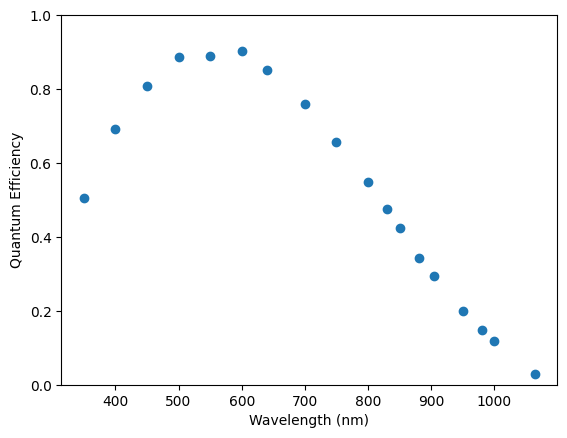

[13.73204183  0.82884671]


In [7]:
wavelengths = np.array([640, 700, 750, 800, 830, 850, 880, 905, 950, 980, 1000, 1064])
exp_times = np.array([2, 3, 3, 4, 4, 4, 4.5, 4, 8, 4.5, 4.5, 120])
pd_dark_vals = 10 ** -13 * np.array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])
pd_gray_vals = 10 ** -10 * np.array([6.48, 5.37, 6.33, 6.34, 7.33, 8.21, 10.1, 12.6, 8.93, 20.9, 27.1, 1.82])
img_dark_vals = np.array([187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187])
img_gray_vals = np.array([9911, 9938, 9454, 9970, 9707, 9571, 10484, 9844, 9415, 9183, 9797, 8321])
pix_area = 10 ** -6
gain = 1 / 1.03
cosmosQE = QECalc(wavelengths, exp_times, pd_dark_vals, pd_gray_vals,
                  img_dark_vals, img_gray_vals, pix_area, gain, thorlabs_pd,
                  pd_pos=np.array([32.0, 1.5]), sensor_pos=np.array([32.67 + 5/16,0]),
                  sensor_size=3.19, int_sphere_port=4)
wheel2wavelengths = np.array([350, 400, 450, 500, 550, 600])
wheel2exp_times = np.array([20, 8, 3, 2.5, 2.5, 2.5])
wheel2pd_dark_vals = 10 ** -13 * np.array([-1, -0.5, -0.5, -0.5, -1, -1])
wheel2pd_gray_vals = 10 ** -10 * np.array([0.266, 0.753, 2.54, 3.34, 4.05, 4.20])
wheel2img_dark_vals = np.array([187, 187, 187, 187, 187, 187])
wheel2img_gray_vals = np.array([9040, 9668, 9251, 9158, 9773, 9217])
cosmosQE.add_points(wheel2wavelengths, wheel2exp_times, wheel2pd_dark_vals, wheel2pd_gray_vals,
                    wheel2img_dark_vals, wheel2img_gray_vals)
cosmosQE.plot_qe()
print(cosmosQE.get_depl_depth())

In [31]:
# In this folder, each filter should have just 1 dark image stack and 1 gray image stacks
my_dir = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Quantum Efficiency/HS_HG_GS'
qe_stacks = get_stacks(my_dir, get_mean_img=True, get_var_img=True)

Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Quantum Efficiency/HS_HG_GS/HighSHighG_GS_raw_2000ms_SC_F1A 2024 May 07 11_05_13.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Quantum Efficiency/HS_HG_GS/HighSHighG_GS_raw_2000ms_SO_F1A 2024 May 07 11_05_30.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Quantum Efficiency/HS_HG_GS/HighSHighG_GS_raw_4500ms_SC_F7A 2024 May 07 11_10_34.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Quantum Efficiency/HS_HG_GS/HighSHighG_GS_raw_4500ms_SO_F7A 2024 May 07 11_10_56.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain

In [82]:
# Sort stacks by filter position
qe_stacks = sorted(qe_stacks, key=lambda x: x['filename'])
qe_stacks_gray = [stack for stack in qe_stacks if 'SO' in stack['filename']]
qe_stacks_dark = [stack for stack in qe_stacks if 'SC' in stack['filename']]
filters_gray = [stack['filename'].split('F')[-1] for stack in qe_stacks_gray]
filters_dark = [stack['filename'].split('F')[-1] for stack in qe_stacks_dark]
if filters_gray != filters_dark:
    raise ValueError('Gray and dark stacks do not match.')
filter_wavelengths = np.array([filter_dict[pos] for pos in filters_gray])
mean_imgs_gray = [stack['mean_img'] for stack in qe_stacks_gray]
mean_imgs_dark = [stack['mean_img'] for stack in qe_stacks_dark]
var_imgs_gray = [stack['var_img'] for stack in qe_stacks_gray]
mean_gray_vals = np.array([np.mean(img) for img in mean_imgs_gray])
mean_dark_vals = np.array([np.mean(img) for img in mean_imgs_dark])

In [77]:
gain = cosmos_gain_dict['XRgain_HSHGGS']
# Check that variance in pixel values is dominated by source shot noise
for i, stack in enumerate(filters_gray):
    print(var_imgs_gray[i].mean(), (mean_imgs_gray[i] - mean_imgs_dark[i]).mean() / gain ** 2)

11245.802014441648 10402.097716617642
11300.38077758095 10438.333128091464
10943.765801776717 9857.51020037393
11407.792682256932 10466.100841184283
11245.956286571705 10137.153790591881
11124.599494639097 9960.435903790078
11351.504628625822 10322.368855509007
12252.718193108098 11092.405305543449
10822.157533204756 9761.65448916403


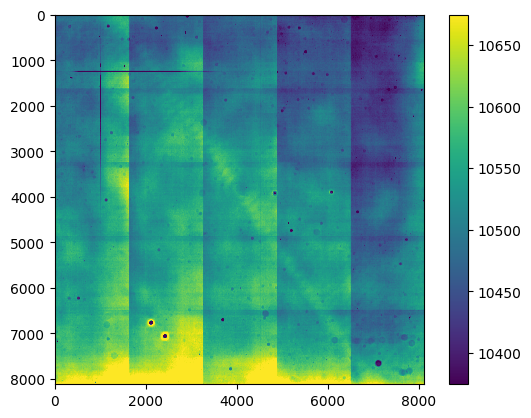

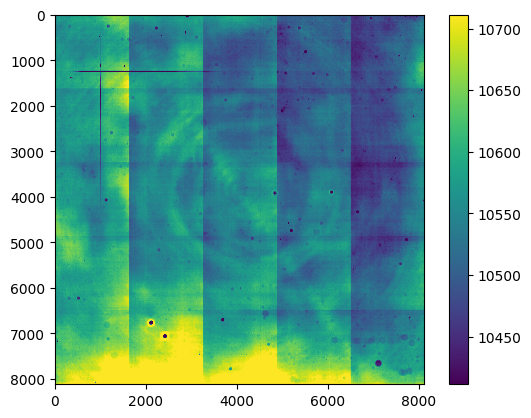

In [86]:
plt.imshow(mean_imgs_gray[0], vmin=mean_gray_vals[0] - 150, vmax=mean_gray_vals[0] + 150)
plt.colorbar()
plt.show()
plt.imshow(mean_imgs_gray[1], vmin=mean_gray_vals[1] - 150, vmax=mean_gray_vals[1] + 150)
plt.colorbar()
plt.show()

In [35]:
for filedata in stack:
    # Extract filter number
    filter_num = filedata['baseFileName'].split('_F')[1].split(' ')[0]
    filedata['filter_num'] = filter_num
    filedata['wavelength'] = filter_dict[filter_num]
    # Identify whether shutter is open or closed
    if '_SC_' in filedata['baseFileName']:
        filedata['exposure_type'] = 'Dark'
    elif '_SO_' in filedata['baseFileName']:
        filedata['exposure_type'] = 'Gray'
    signals = filedata['imagestack'].mean(axis=(1,2))
    filedata['mean_signal'] = np.mean(signals)
    filedata['min_signal'] = np.min(signals)
    filedata['max_signal'] = np.max(signals)

wavelengths = np.array([640, 700, 750, 800, 830, 850, 880, 905, 950])
exp_times = np.array([2, 3, 3, 4, 4, 4, 4.5, 4, 8])
pd_dark_vals = 10 ** -13 * np.array([-1, -1, -1, -1, -1, -1, -1, -1, -1])
pd_gray_vals = 10 ** -10 * np.array([6.48, 5.37, 6.33, 6.34, 7.33, 8.21, 10.1, 12.6, 8.93])
img_dark_vals = np.zeros_like(wavelengths)
img_gray_vals = np.zeros_like(wavelengths)
img_gray_vals_low = np.zeros_like(wavelengths)
img_gray_vals_high = np.zeros_like(wavelengths)
for wavelength in wavelengths:
    dark_files = [filedata for filedata in stack if filedata['wavelength'] == wavelength and filedata['exposure_type'] == 'Dark']
    gray_files = [filedata for filedata in stack if filedata['wavelength'] == wavelength and filedata['exposure_type'] == 'Gray']
    if len(dark_files) != 1 or len(gray_files) != 1:
        raise ValueError('Incorrect number of dark or gray files for wavelength {}'.format(wavelength))
    img_dark_vals[wavelengths == wavelength] = dark_files[0]['mean_signal']
    img_gray_vals[wavelengths == wavelength] = gray_files[0]['mean_signal']
    img_gray_vals_low[wavelengths == wavelength] = gray_files[0]['min_signal']
    img_gray_vals_high[wavelengths == wavelength] = gray_files[0]['max_signal']

pix_area = 10 ** -6
gain = 1 / 1.03
testQE = QECalc(wavelengths, exp_times, pd_dark_vals, pd_gray_vals,
                  img_dark_vals, img_gray_vals, pix_area, gain, thorlabs_pd,
                  pd_pos=np.array([32.0, 1.5]), sensor_pos=np.array([32.67 + 5/16,0]),
                  sensor_size=3.19, int_sphere_port=4)
testQE2 = QECalc(wavelengths, exp_times, pd_dark_vals, pd_gray_vals,
                  img_dark_vals, img_gray_vals_high, pix_area, gain, thorlabs_pd,
                  pd_pos=np.array([32.0, 1.5]), sensor_pos=np.array([32.67 + 5/16,0]),
                  sensor_size=3.19, int_sphere_port=4)

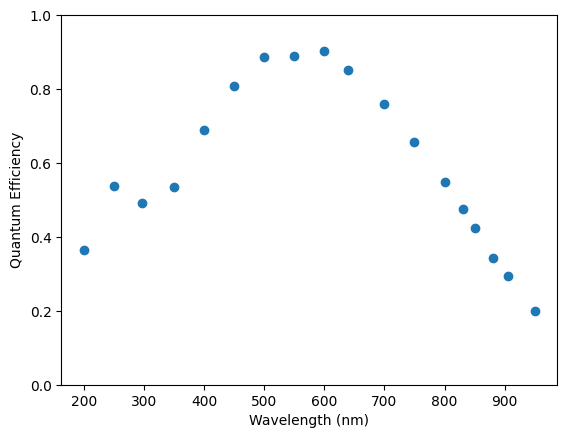

In [36]:
testQE2.add_qe_points([200, 250, 297, 350, 400, 450, 500, 550, 600], [0.364, 0.538, 0.492, 0.535, 0.688, 0.809, 0.887, 0.890, 0.903])
testQE2.plot_qe()

In [8]:
# Find the current file's directory
this_dir = os.path.abspath('')
data_folder = this_dir + '/data/'
imx487_arr = np.genfromtxt(data_folder + 'IMX487_QE.csv', delimiter=',')
qcmos_arr = np.genfromtxt(data_folder + 'qCMOS_QE_2.csv', delimiter=',')
cosmos_arr = np.genfromtxt(data_folder + 'cosmos_qe_datasheet.csv', delimiter=',')

NameError: name 'testQE2' is not defined

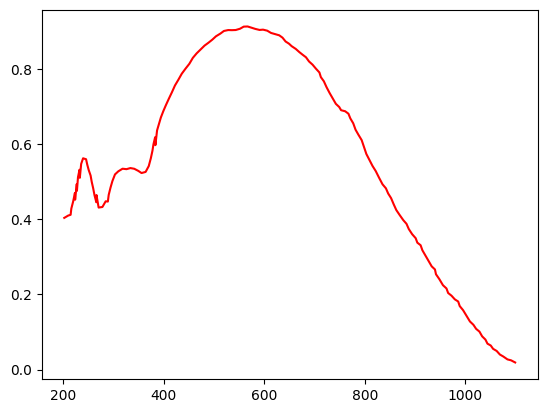

In [9]:
plt.plot(cosmos_arr[:,0], cosmos_arr[:,1], label='COSMOS (Datasheet)', color='red')
plt.scatter(testQE2.wavelengths, testQE2.qe_vals, label='COSMOS (MKI Prelim. Data)', color='red')
plt.plot(imx487_arr[:,0] / 10, imx487_arr[:,1], label='Sony IMX487 (Datasheet)', color='green')
plt.plot(qcmos_arr[:,0] / 10, qcmos_arr[:,1], label='ORCA-Quest 2 (Datasheet)', color='blue')
plt.xlabel('Wavelength (nm)', fontsize=16)
plt.ylabel('Quantum Efficiency', fontsize=16)
plt.ylim(0, 1.0)
# Make legend have 2 columns
# Put legend above plot
plt.legend(ncol=1, loc='upper right', fontsize=11)
plt.gcf().set_size_inches(8, 5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [2]:
cms_dir = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/PTC Ramps/CMS'
test = get_stacks(cms_dir, get_mean_img=True, get_var_img=True, num_imgs=0)

Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/PTC Ramps/CMS/CMS_RS_dark_1us_-25C 2024-10-05 14_57_27.fits


In [19]:
np.sqrt(np.median(test[0]['var_img']))

2.693426341028366

Some code to calculate average photodiode readings for COSMOS PTC ramps

In [46]:
import pandas as pd
pd_datafile = '/Volumes/LAYDENUSB/ramp_pd_readings.csv'
# Load as pandas dataframe
pd_data = pd.read_csv(pd_datafile, header=None)
# Name the columns datetime, pd_reading, and photodetector_reading
pd_data.columns = ['datetime', 'pd_reading', 'photodetector_reading']
# datetime is in format MM-DD-HH:MM:SS.ms. Convert to datetime object, all with the year 2024
pd_data['datetime'] = '2024-' + pd_data['datetime']
pd_data['datetime'] = pd.to_datetime(pd_data['datetime'], format='%Y-%m-%d-%H:%M:%S.%f')
def get_avg_reading(start_time, end_time, date, wavelength=640, pix_size=10):
    '''Get the average reading of the photodetector between two times.'''
    start_time = date + ' ' + start_time
    end_time = date + ' ' + end_time
    start_time = pd.to_datetime(start_time)
    end_time = pd.to_datetime(end_time)
    ramp_readings = pd_data[(pd_data['datetime'] >= start_time) & (pd_data['datetime'] <= end_time)]
    # Only get values for when shutter is open, i.e. when photodetector reading is between 0.39 and 0.41
    ramp_readings = ramp_readings[(ramp_readings['photodetector_reading'] >= 0.39) & (ramp_readings['photodetector_reading'] <= 0.41)]
    avg_pd_reading = ramp_readings['pd_reading'].mean()
    thorlabs_pd_response = thorlabs_pd.get_response(wavelength)
    # Get photon energy flux in ergs/cm^2/s
    phot_energy_flux = avg_pd_reading / thorlabs_pd_response * 10 ** 7
    # Convert photon energy rate from ergs/s/cm^2 to photons/s/cm^2
    phot_energy = h * c / (wavelength * 10 ** -7)
    abs_phot_flux = phot_energy_flux / phot_energy
    # Convert to photons/s/pix
    pix_size = (pix_size ** 2) * 10 ** -8
    abs_phot_flux = abs_phot_flux * pix_size
    return abs_phot_flux

print(get_avg_reading('14:34:00', '15:23:00', '2024-10-07'))

2110.9093049705884
